<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/AIcontents/refactored/refactord_include_I_CSVtoJSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount

In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

# Emotion

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-officialss

     |████████████████████████████████| 4.4 MB 7.2 MB/s 
ERROR: Could not find a version that satisfies the requirement tf-models-officialss (from versions: none)
ERROR: No matching distribution found for tf-models-officialss


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/final_train_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Arabian_test_data',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1333 files belonging to 4 classes.
Using 1067 files for training.
Found 1333 files belonging to 4 classes.
Using 266 files for validation.
Found 172 files belonging to 4 classes.


In [5]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')

  from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

Review: b'SILENCE.'
Label : 2 (2)
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 4223 1012  102    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - der ice heard thetramp hiss of feet and looked round, only glad that if at all last she could see only the queen.'
Label : 1 (1)
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  4315  3256  2657  1996  6494  8737 19074  1997  2519]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'al - ice he was having too much vexed me to ever speak, and for she first had nev - er, in making all save her life, beentalked to in that overly rude way.'
Label : 2 (2)
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2632  1011  3256  2002  2001  2383  2205  

tf.Tensor([[0.6143576 0.6057317 0.6500721 0.6750274]], shape=(1, 4), dtype=float32)
     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 636 kB 45.2 MB/s 
     |████████████████████████████████| 37.1 MB 89 kB/s 
     |████████████████████████████████| 211 kB 47.2 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 352 kB 48.3 MB/s 
Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
1067/1067 [==============================] - 204s 175ms/step - loss: 1.3097 - sparse_categorical_accuracy: 0.6214 - val_loss: 1.0116 - val_sparse_categorical_accuracy: 0.7782
Epoch 2/3
1067/1067 [==============================] - 78s 73ms/step - loss: 0.5885

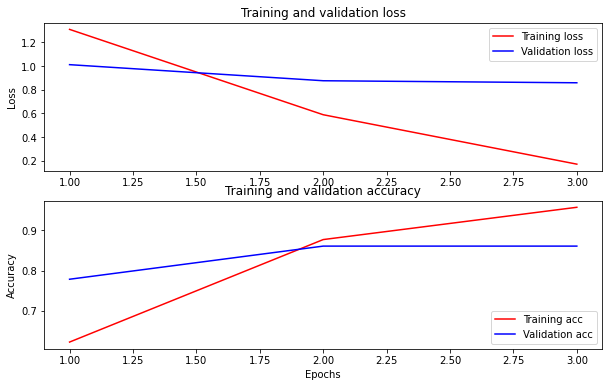

In [6]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
! pip install -q tf-models-official
from official.nlp import optimization

loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [7]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

172
[0.35157856 0.00772191 0.999835   0.04784156]


,sentence,mark,predicted_mark
0,"b' Then he sprang up, and with one blow of his...",2,2
1,"b' But no, it will be better if I throw you in...",2,2
2,"b' The bird replied, My good master, the light...",3,3
3,b' This kind maiden has rescued you from a ter...,1,1
4,"b' Is this, continued Zobeida, growing more an...",2,2
...,...,...,...
167,b' At last I begged her to cease grieving for ...,3,3
168,"b' Oh, lucky meeting.'",1,1
169,b' At length they reached the capital of China...,0,0
170,"b' In spite of her anger, there was something ...",1,1


# NER

In [8]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-09-26 16:39:20--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-09-26 16:39:21--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-09-26 16:39:21--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:44

In [9]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')\
        .setCustomBounds(['\n'])

    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline

In [10]:
conll_pipeline = get_ann_pipeline ()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [11]:
#####-----parsed example-----######
parsed = conll_pipeline.annotate ("Peter loves you")

for key in parsed.keys():
    print(key,': ',parsed[key])
conll_lines=''

for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

    conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)


print(conll_lines)

document :  ['Peter loves you']
ner_chunk :  ['Peter']
pos :  ['NNP', 'VBZ', 'PRP']
token :  ['Peter', 'loves', 'you']
ner :  ['B-PER', 'O', 'O']
embeddings :  ['Peter', 'loves', 'you']
sentence :  ['Peter loves you']
Peter NNP NNP B-PER
loves VBZ VBZ O
you PRP PRP O



In [12]:
sentences=['Peter Parker Baker is in a baby blue Cadillac.','I love you.','Hanhee fell a sleep']

def get_person_entity(sentences):
  data=[]
  for sentence in sentences:
    parsed = conll_pipeline.annotate (sentence)
    line_entity=[]

    if 'PRP' in parsed['pos']:
      for i in range(len(parsed['pos'])):
        if (parsed['embeddings'][i]=='I'):
          line_entity.append(parsed['embeddings'][i])


    if ('B-PER' in parsed['ner']):
      for i in range(len(parsed['ner'])):
        if (parsed['ner'][i]=='B-PER'):
          name=parsed['embeddings'][i]
          line_entity.append(name)
        elif parsed['ner'][i]=='I-PER':
          line_entity[-1]+=' '+parsed['embeddings'][i]
      data.append(line_entity)
    else:
      data.append(line_entity)
    print(line_entity)
  return data

print(get_person_entity(sentences))

['Peter Parker Baker']
['I']
['Hanhee']
[['Peter Parker Baker'], ['I'], ['Hanhee']]


In [13]:
import pandas as pd
df=pd.read_csv('result.csv')
df['person']=get_person_entity(df['sentence'])
display(df)
df.to_csv('Entity_Predicted_result.csv')

[]
['I', 'I', 'I']
['I', 'I']
['I']
['I', 'Zobeida']
[]
[]
[]
[]
[]
['I', 'Alas']
['I']
[]
[]
['I']
['I']
['Sadie']
[]
['I']
[]
[]
['Sultan']
[]
['I', 'I', 'Wretch']
['I', 'I', 'I']
[]
[]
['Amina', 'Sadie']
[]
['I', 'I']
[]
['I']
['I', 'I', 'I']
[]
['Zobeida', 'Calenders']
[]
['I', 'I']
['Douban']
[]
[]
['Sultan']
[]
['I']
['I']
['Zobeida']
['I', 'Heaven']
['I']
[]
['I', 'I']
['I', 'I']
['I']
[]
[]
['I', 'I']
[]
['I']
['I', 'I', 'I', 'I']
['I']
['I']
[]
['Sultan']
['Sultan']
[]
['Zobeida']
['Zobeida']
['Saouy']
['Sultan']
[]
['I']
['I']
['O Fortune']
[]
['I', 'I', 'I']
[]
['I']
['I']
[]
['I']
['I', 'Rejoice']
['I']
[]
['Sadia']
['I', 'I', 'I', 'Alnaschar']
[]
[]
[]
['Zobeida', 'Sadie', 'Amina']
['I']
['Whoso']
[]
[]
['I']
[]
[]
['Marzavan']
['I']
['I', 'I']
[]
[]
['Zobeida']
[]
['Sultan', "Aladdin's", 'Sultan']
['I']
[]
[]
['I', 'I']
['I', 'I']
['I', 'I']
['I']
['King Armanos']
['I']
[]
[]
[]
['Fisherman']
[]
[]
['I']
[]
[]
[]
[]
['I']
[]
['I']
['I', 'I', 'vizir']
[]
[]
['I', 'Hasten']

,Unnamed: 0,sentence,mark,predicted_mark,person
0,0,"b' Then he sprang up, and with one blow of his...",2,2,[]
1,1,"b' But no, it will be better if I throw you in...",2,2,"[I, I, I]"
2,2,"b' The bird replied, My good master, the light...",3,3,"[I, I]"
3,3,b' This kind maiden has rescued you from a ter...,1,1,[I]
4,4,"b' Is this, continued Zobeida, growing more an...",2,2,"[I, Zobeida]"
...,...,...,...,...,...
167,167,b' At last I begged her to cease grieving for ...,3,3,[I]
168,168,"b' Oh, lucky meeting.'",1,1,[]
169,169,b' At length they reached the capital of China...,0,0,[]
170,170,"b' In spite of her anger, there was something ...",1,1,[Zobeida]


# Data화

In [14]:
data=pd.read_csv('Entity_Predicted_result.csv')
display(data)

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,"b' Then he sprang up, and with one blow of his...",2,2,[]
1,1,1,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']"
2,2,2,"b' The bird replied, My good master, the light...",3,3,"['I', 'I']"
3,3,3,b' This kind maiden has rescued you from a ter...,1,1,['I']
4,4,4,"b' Is this, continued Zobeida, growing more an...",2,2,"['I', 'Zobeida']"
...,...,...,...,...,...,...
167,167,167,b' At last I begged her to cease grieving for ...,3,3,['I']
168,168,168,"b' Oh, lucky meeting.'",1,1,[]
169,169,169,b' At length they reached the capital of China...,0,0,[]
170,170,170,"b' In spite of her anger, there was something ...",1,1,['Zobeida']


In [15]:
#등장인물 추출
import ast
persons=[]

for person_line in data['person']:
  person_line = ast.literal_eval(person_line) 
  for p in person_line:
    persons.append(p)
persons=set(persons)
print(persons)
display(data)

{"Aladdin's", 'Fisherman', 'Mad', 'King Armanos', 'Heaven', 'Sultan', 'Marzavan', 'Rejoice', 'Wretch', 'O Fortune', 'vizir', 'Hasten', 'Zobeida', 'Grant', 'Alas', 'Amina', 'Douban', 'Whoso', 'Alnaschar', 'Sadie', 'Sadia', 'I', 'Hindbad', 'Saouy', 'Calenders'}


,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person
0,0,0,"b' Then he sprang up, and with one blow of his...",2,2,[]
1,1,1,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']"
2,2,2,"b' The bird replied, My good master, the light...",3,3,"['I', 'I']"
3,3,3,b' This kind maiden has rescued you from a ter...,1,1,['I']
4,4,4,"b' Is this, continued Zobeida, growing more an...",2,2,"['I', 'Zobeida']"
...,...,...,...,...,...,...
167,167,167,b' At last I begged her to cease grieving for ...,3,3,['I']
168,168,168,"b' Oh, lucky meeting.'",1,1,[]
169,169,169,b' At length they reached the capital of China...,0,0,[]
170,170,170,"b' In spite of her anger, there was something ...",1,1,['Zobeida']


In [16]:
connection=[]
connections=[]

for p in data['person']:
  p=ast.literal_eval(p)
  if p:
    connection.append(p)
    if len(connection)>2:connection.pop(0)
  c=sum(connection, [])
  connections.append(set(c))
data['connection']=connections
display(data)
data.to_csv('connection_Predicted_result.csv')

,Unnamed: 0,Unnamed: 0.1,sentence,mark,predicted_mark,person,connection
0,0,0,"b' Then he sprang up, and with one blow of his...",2,2,[],{}
1,1,1,"b' But no, it will be better if I throw you in...",2,2,"['I', 'I', 'I']",{I}
2,2,2,"b' The bird replied, My good master, the light...",3,3,"['I', 'I']",{I}
3,3,3,b' This kind maiden has rescued you from a ter...,1,1,['I'],{I}
4,4,4,"b' Is this, continued Zobeida, growing more an...",2,2,"['I', 'Zobeida']","{Zobeida, I}"
...,...,...,...,...,...,...,...
167,167,167,b' At last I begged her to cease grieving for ...,3,3,['I'],{I}
168,168,168,"b' Oh, lucky meeting.'",1,1,[],{I}
169,169,169,b' At length they reached the capital of China...,0,0,[],{I}
170,170,170,"b' In spite of her anger, there was something ...",1,1,['Zobeida'],"{Zobeida, I}"


In [17]:
#################
#  0 : 중립      #
#  1 : 행복      #
#  2 : 분노      #
#  3 : 슬픔      #
#################

# 관계도 csv 구성
graph_keys=[]
graph_values=[]

import itertools
for i in range(len(data)):
  if len(data.loc[i]['connection'])>=2:
    comb=itertools.combinations(data.loc[i]['connection'],2)
    for c in comb:
      if c in graph_keys:
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1
      else:
        graph_keys.append(c)
        graph_values.append([0,0,0,0])
        graph_values[graph_keys.index(c)][data.loc[i]['predicted_mark']]+=1

print(graph_keys)
print(graph_values)

print(len(graph_keys))
print(len(graph_values))

connection_data=pd.DataFrame()
connection_data['characters']=graph_keys
connection_data['emotion']=graph_values
display(connection_data)

[('Zobeida', 'I'), ('Alas', 'Zobeida'), ('Alas', 'I'), ('I', 'Sadie'), ('I', 'Sultan'), ('I', 'Wretch'), ('Wretch', 'Sultan'), ('Amina', 'I'), ('Amina', 'Sadie'), ('Zobeida', 'Calenders'), ('I', 'Calenders'), ('I', 'Douban'), ('Douban', 'Sultan'), ('Zobeida', 'Heaven'), ('I', 'Heaven'), ('Zobeida', 'Sultan'), ('Zobeida', 'Saouy'), ('Sultan', 'Saouy'), ('I', 'O Fortune'), ('I', 'Rejoice'), ('Sadia', 'I'), ('Sadia', 'Alnaschar'), ('I', 'Alnaschar'), ('Amina', 'Zobeida'), ('Amina', 'Alnaschar'), ('Sadie', 'I'), ('Sadie', 'Zobeida'), ('Sadie', 'Alnaschar'), ('I', 'Zobeida'), ('Zobeida', 'Alnaschar'), ('Zobeida', 'Amina'), ('Zobeida', 'Sadie'), ('Whoso', 'I'), ('Marzavan', 'I'), ('Zobeida', "Aladdin's"), ("Aladdin's", 'Sultan'), ('I', "Aladdin's"), ('I', 'King Armanos'), ('I', 'Fisherman'), ('I', 'vizir'), ('I', 'Hasten'), ('vizir', 'Hasten'), ('I', 'Mad'), ('I', 'Hindbad'), ('Hindbad', 'Sultan'), ('Grant', 'Hindbad'), ('Grant', 'I')]
[[5, 4, 4, 4], [0, 0, 0, 1], [2, 0, 1, 1], [1, 5, 4, 0],

,characters,emotion
0,"(Zobeida, I)","[5, 4, 4, 4]"
1,"(Alas, Zobeida)","[0, 0, 0, 1]"
2,"(Alas, I)","[2, 0, 1, 1]"
3,"(I, Sadie)","[1, 5, 4, 0]"
4,"(I, Sultan)","[2, 5, 5, 4]"
5,"(I, Wretch)","[1, 1, 1, 1]"
6,"(Wretch, Sultan)","[0, 0, 1, 0]"
7,"(Amina, I)","[0, 5, 1, 0]"
8,"(Amina, Sadie)","[0, 5, 1, 0]"
9,"(Zobeida, Calenders)","[0, 0, 1, 2]"


In [32]:
#csv to json
import json 
from collections import OrderedDict

#선언
file_data=OrderedDict()
file_data['nodes']=[]
file_data['links']=[]
persons=list(persons)

#감정사전선언
emotion_dict={0 : 'neutral',  
1 : 'happy',   
2 : 'angry',
3 : 'sad'
}
#node
for i in range(len(persons)):
  node=OrderedDict()
  node['id']=persons[i]
  node['group']=i
  file_data['nodes'].append(node)

# #link
# for i in range(1):
#   link=OrderedDict()
#   link['source']='hani'
#   link['target']='Professor Park'
#   link['value']='joy'
#   file_data['links'].append(link)

#new_link
for i in range(len(connection_data)):
  link=OrderedDict()
  link['source']=connection_data.loc[i]['characters'][0]
  link['target']=connection_data.loc[i]['characters'][1]
  emotions_list=connection_data.loc[i]['emotion']
  link['value']=emotion_dict[emotions_list.index(max(emotions_list))]
  file_data['links'].append(link)

print(json.dumps(file_data,indent='\t'))

#원본 파일 불러와서 덤프 찍어본다음 형태 체크하면 되겠다

{
	"nodes": [
		{
			"id": "Aladdin's",
			"group": 0
		},
		{
			"id": "Fisherman",
			"group": 1
		},
		{
			"id": "Mad",
			"group": 2
		},
		{
			"id": "King Armanos",
			"group": 3
		},
		{
			"id": "Heaven",
			"group": 4
		},
		{
			"id": "Sultan",
			"group": 5
		},
		{
			"id": "Marzavan",
			"group": 6
		},
		{
			"id": "Rejoice",
			"group": 7
		},
		{
			"id": "Wretch",
			"group": 8
		},
		{
			"id": "O Fortune",
			"group": 9
		},
		{
			"id": "vizir",
			"group": 10
		},
		{
			"id": "Hasten",
			"group": 11
		},
		{
			"id": "Zobeida",
			"group": 12
		},
		{
			"id": "Grant",
			"group": 13
		},
		{
			"id": "Alas",
			"group": 14
		},
		{
			"id": "Amina",
			"group": 15
		},
		{
			"id": "Douban",
			"group": 16
		},
		{
			"id": "Whoso",
			"group": 17
		},
		{
			"id": "Alnaschar",
			"group": 18
		},
		{
			"id": "Sadie",
			"group": 19
		},
		{
			"id": "Sadia",
			"group": 20
		},
		{
			"id": "I",
			"group": 21
		},
		{
			"id": "Hindbad",
			"group": 22
		},


In [33]:
with open("data.json", "w") as f:
  json.dump(file_data, f)


In [22]:
#원본체크코드
import json

file_path = "./miserables.json"
with open(file_path, "r") as json_file:
    json_data = json.load(json_file)
print(json.dumps(json_data,indent='\t'))

# test

In [26]:
a=[1,2,3,3]
print(a.index(max(a)))

2


In [28]:
#link test
for i in range(len(connection_data)):
  print(connection_data.loc[i]['characters'])

('Zobeida', 'I')
('Alas', 'Zobeida')
('Alas', 'I')
('I', 'Sadie')
('I', 'Sultan')
('I', 'Wretch')
('Wretch', 'Sultan')
('Amina', 'I')
('Amina', 'Sadie')
('Zobeida', 'Calenders')
('I', 'Calenders')
('I', 'Douban')
('Douban', 'Sultan')
('Zobeida', 'Heaven')
('I', 'Heaven')
('Zobeida', 'Sultan')
('Zobeida', 'Saouy')
('Sultan', 'Saouy')
('I', 'O Fortune')
('I', 'Rejoice')
('Sadia', 'I')
('Sadia', 'Alnaschar')
('I', 'Alnaschar')
('Amina', 'Zobeida')
('Amina', 'Alnaschar')
('Sadie', 'I')
('Sadie', 'Zobeida')
('Sadie', 'Alnaschar')
('I', 'Zobeida')
('Zobeida', 'Alnaschar')
('Zobeida', 'Amina')
('Zobeida', 'Sadie')
('Whoso', 'I')
('Marzavan', 'I')
('Zobeida', "Aladdin's")
("Aladdin's", 'Sultan')
('I', "Aladdin's")
('I', 'King Armanos')
('I', 'Fisherman')
('I', 'vizir')
('I', 'Hasten')
('vizir', 'Hasten')
('I', 'Mad')
('I', 'Hindbad')
('Hindbad', 'Sultan')
('Grant', 'Hindbad')
('Grant', 'I')
